<a href="https://colab.research.google.com/github/givatop/AI-HAKATON/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D1%81%D0%BF%D0%BE%D1%80%D1%87%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D0%BD%D0%BE%D1%80%D0%BC_%D1%84%D0%BE%D1%82%D0%BE_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Подключение нужных слоев из модуля tensorflow.keras.layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model

from glob import glob

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Матрица ошибок классификатора
from PIL import Image # Отрисовка изображений
from sklearn.model_selection import train_test_split # Разделение на обучающую и проверочную/тестовую выборку

import numpy as np # Библиотека работы с массивами
import pandas as pd

import matplotlib.pyplot as plt # Отрисовка графиков
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

import os # Для работы с файлами
import random # Генерация случайных чисел
import gdown # Подключение модуля для загрузки данных из облака

In [ ]:
pip freeze #использованные версии библиотек

absl-py==1.4.0
aiohttp==3.8.5
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.3.1
altair==4.2.2
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.4.1
arviz==0.15.1
astropy==5.3.3
astunparse==1.6.3
async-timeout==4.0.3
attrs==23.1.0
audioread==3.0.0
autograd==1.6.2
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blinker==1.4
blis==0.7.10
blosc2==2.0.0
bokeh==3.2.2
bqplot==0.12.40
branca==0.6.0
build==1.0.3
CacheControl==0.13.1
cachetools==5.3.1
catalogue==2.0.9
certifi==2023.7.22
cffi==1.15.1
chardet==5.2.0
charset-normalizer==3.2.0
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.27.4.1
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.2
cons==0.4.6
contextlib2==21.6.0
contourpy==1.1.0
convertdate==2.4.0
cryptography==41.0.3
cufflinks==0.17.3
cvxopt==1.3.2
cvxpy==1.3.2
cycler==0.11.0
cymem==2.0.7
Cython==3.0.2
dask==2023.8.1
datascie

## 1. Загрузка данных

In [ ]:
# Загружаем zip-архив с датасетом на диск виртуальной машины colab
gdown.download('https://lodmedia.hb.bizmrg.com/case_files/1026328/train_dataset_altai.zip', None)

Downloading...
From: https://lodmedia.hb.bizmrg.com/case_files/1026328/train_dataset_altai.zip
To: /content/train_dataset_altai.zip
100%|██████████| 6.52G/6.52G [03:58<00:00, 27.3MB/s]


'train_dataset_altai.zip'

In [ ]:
# Разархивация в директорию '/content'
!unzip -qo "train_dataset_altai.zip" -d /content/data

In [ ]:
# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/data/'

In [ ]:
os.listdir(IMAGE_PATH)

['submission.csv',
 'Фотоловушка Иониха',
 'imgs',
 'broken_imgs',
 'фотоловушка новое',
 'clear_imgs',
 'readme.md']

In [ ]:
f=open('/content/data/readme.md')
readme = f.read()
print(readme)

### Добро пожаловать на кейс ФГБОУ ВО "Алтайский государственный университет" "Классификация снимков с фотоловушек"!
***
#### Структура датасета:
- broken_imgs - содержит один кадр, полностью белый.
- clear_imgs - содержит 319 кадров с животными и без дефектов.
- imgs - содержит 323 кадра, в основном с дефектами, присутствует около 30 нормальных
кадров.
- Фотоловушка Иониха - содержит 420 кадров, в основном без дефектов и почти все
сделаны в ночное время.
- фотоловушки новое - содержит примерно пополам фото с дефектами и без. Суммарно в
папке "фотоловушки новое" 3254 неразмеченных кадров.
- ```submission.csv``` - файл с примером результата для отправки в автоматическую систему оценивания


#### Пример базового результата для отправки
Базовый результат для отправки представляет собой csv-файл (разделитель - ТОЧКА С ЗАПЯТОЙ), состоящий из 4 колонок:
- **filename** - название файла в виде ```dataset/folder/filename```
- **broken** - является ли изображение "битым", неподходящим по условию

## 2. Сбор размеченных данных для обучения модели

In [ ]:
pathes=['/content/data/фотоловушка новое/flхатка20160929/100EK113', '/content/data/imgs', '/content/data/clear_imgs']

In [ ]:
img_hatka=list(glob(os.path.join(pathes[0], '*.JPG'))) #изображения с камеры с бобровой(видимо) хаткой при ручной разметке все оказались подходящего качества
y_hatka=[0]*len(img_hatka)

In [ ]:
img_mixed=list(glob(os.path.join(pathes[1], '*.JPG'))) #в папке imgs смешанное содержимое, метки мы расставили исходя из названий файлов
y_mixed=[0 if 'clear' in i else 1 for i in img_mixed]

In [ ]:
img_clear=list(glob(os.path.join(pathes[2], '*.jpg'))) #часть изображений хорошего качества взяли в папке с животными
img_clear+=list(glob(os.path.join(pathes[2], '*.JPG')))
y_clear=[0 for i in img_clear]

In [ ]:
labels=y_clear+y_mixed+y_hatka

In [ ]:
images=img_clear+img_mixed+img_hatka

In [ ]:
len(labels)==len(images)

True

## 3. Предобработка

In [ ]:
# Задание единых размеров изображений

IMG_WIDTH = 32                           # Ширина изображения
IMG_HEIGHT = 32                          # Высота изображения

def preprocessing(images):
  data_images=[]# Пустой список для данных изображений

  for i in range(len(images)):
    try:
      # Открытие и смена размера изображения
      img = Image.open(images[i]).resize((IMG_WIDTH, IMG_HEIGHT))
      # Конвертация изображений в режиме CMYK в режим RGB
      if img.mode == 'CMYK':
        img = img.convert('RGB')
      data_images.append(img)

    except OSError: #если изображение 'битое', заменяем его белой картинкой
      data_images.append(Image.open('/content/data/broken_imgs/PICT0082.JPG').resize((IMG_WIDTH, IMG_HEIGHT)))

  return data_images

In [ ]:
data_images=preprocessing(images=images)

In [ ]:
print(f'В массив собрано {len(data_images)} фотографий, меток {len(labels)}')

В массив собрано 1640 фотографий, меток 1640


In [ ]:
data=[]
for img in data_images:
  img_np = np.array(img)                # Перевод в numpy-массив
  data.append(img_np)

x_data = np.array(data)            # Перевод общего списка изображений в numpy-массив
y_data = np.array(labels)            # Перевод общего списка меток класса в numpy-массив

print(f'Общий массив данных изображений следующей формы: {x_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

Общий массив данных изображений следующей формы: (1640, 32, 32, 3)
Общий массив меток классов следующей формы: (1640,)


In [ ]:
# Нормированние массива изображений
x_data = x_data / 255.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_data, # набор параметров
                                                    y_data,
                                                    train_size=0.7, # процент в тестовую
                                                    shuffle=True, #  перемешивание
                                                    random_state=42) # воспроизводимость

## 4. Обучение модели

**Несколько запусков**

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.998


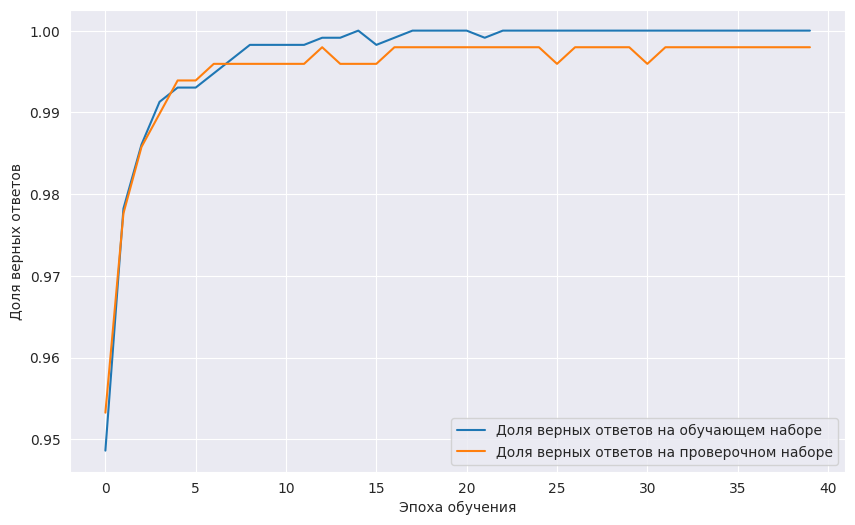





CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 1.0


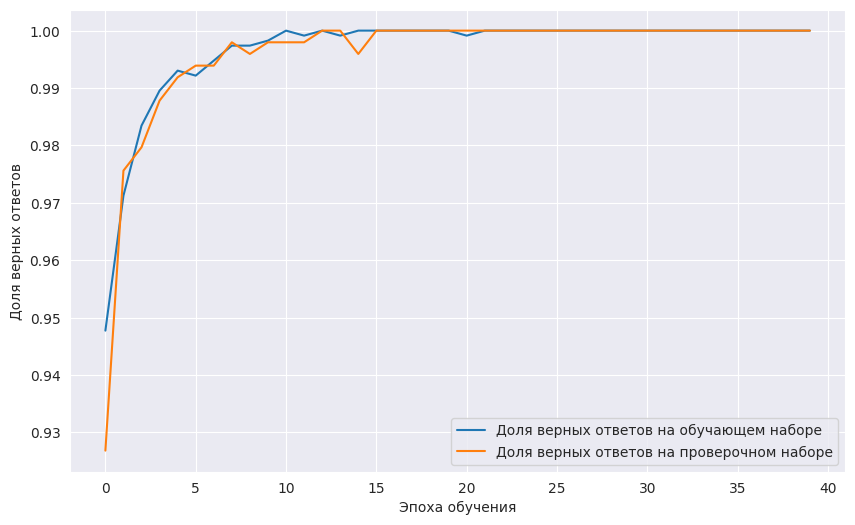





CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs
Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 1.0


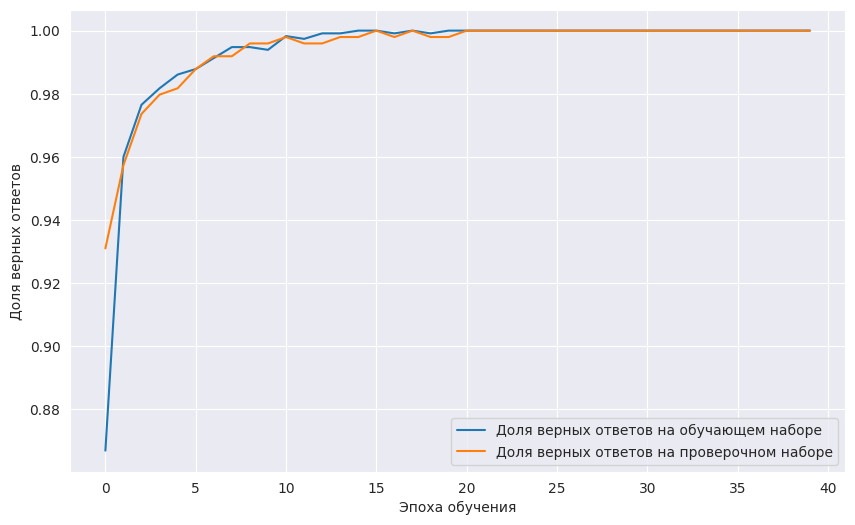





CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.998


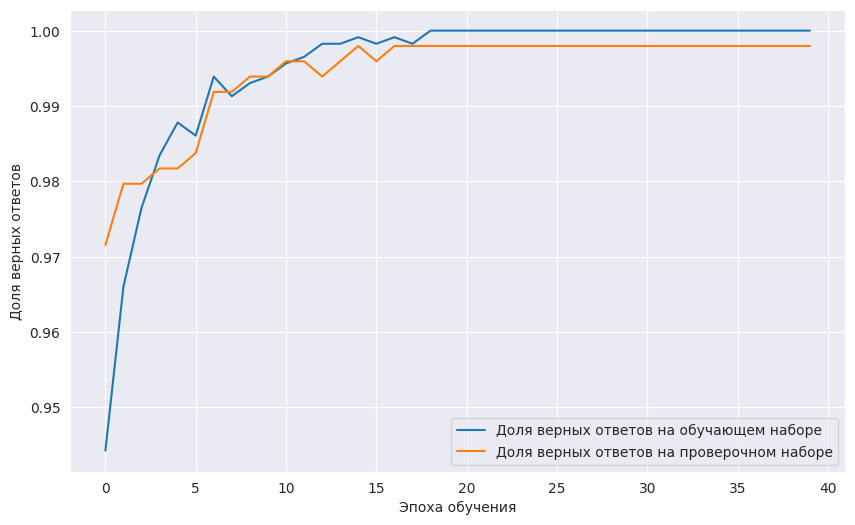





CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs
Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.998


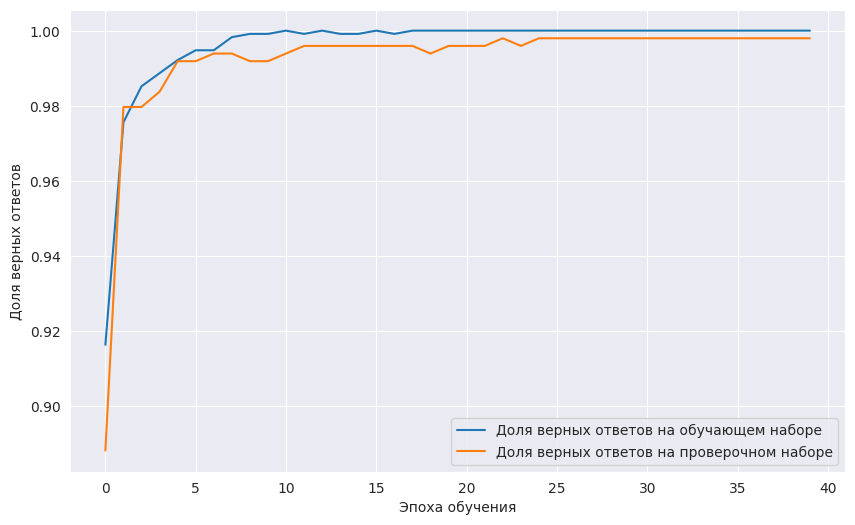





CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


In [ ]:
#время обучения без GPU

# Обучение модели сверточной нейронной сети подготовленных данных
cnt = 5
history_accuracy = []
history_val_accuracy = []
for i in range(cnt):
  model = Sequential()

  model.add(Conv2D(32, (2, 2), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.00002), metrics=['accuracy'])

  store_learning = model.fit(x_train,
                            y_train,
                            validation_data=(x_val, y_val),
                            shuffle=True,
                            batch_size=10,
                            epochs=40,
                            verbose=0)
  history_accuracy.append(store_learning.history['accuracy'])
  history_val_accuracy.append(store_learning.history['val_accuracy'])

  print(f'Обучение №{i+1} завершено. Результаты')
  print(f'Максимальная точность на обучающей выборке: {round(np.array(store_learning.history["accuracy"]).max(), 3)}')
  print(f'Максимальная точность на проверочной выборке: {round(np.array(store_learning.history["val_accuracy"]).max(), 3)}')

  plt.figure(1, figsize=(10, 6))
  plt.plot(store_learning.history['accuracy'],
          label='Доля верных ответов на обучающем наборе')
  plt.plot(store_learning.history['val_accuracy'],
          label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()

  plt.show()
  print('\n'*3)
  %time

In [ ]:
model.summary() #архитектура модели

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        416       
                                                                 
 batch_normalization_4 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                524352    
                                                                 
 dense_9 (Dense)             (None, 2)                

In [ ]:
print(f'Средняя точность на обучающей выборке: {round(np.array(history_accuracy).max(axis=1).mean(), 3)}')
print(f'Максимальная точность на обучающей выборке: {round(np.array(history_accuracy).max(), 3)}')
print(f'Средняя точность на проверочной выборке: {round(np.array(history_val_accuracy).max(axis=1).mean(), 3)}')
print(f'Максимальная точность на проверочной выборке: {round(np.array(history_val_accuracy).max(), 3)}')

Средняя точность на обучающей выборке: 1.0
Максимальная точность на обучающей выборке: 1.0
Средняя точность на проверочной выборке: 0.999
Максимальная точность на проверочной выборке: 1.0


In [ ]:
model.save("bad-good_img.h5")

## 5. Получение предсказания

In [ ]:
model=load_model("bad-good_img.h5")

In [ ]:
test_path='/content/data/test'#прописать путь до загруженных тестовых изображений
x_test=list(glob(os.path.join(test_path, '*.JPG')))
test_data=preprocessing(x_test)

In [ ]:
def get_prediction(data):
  prediction=[1 if i[1]>0.5 else 0 for i in model.predict(data)]
  return prediction


In [ ]:
prediction=get_prediction(test_data)

res=pd.DataFrame()
res['**filename**']=x_test
res['**broken**']=prediction #заменить на prediction
res['**empty**']=[0]*len(res['**filename**'])
res['**animal**']=res['**empty**']

res.sample()

In [ ]:
res.to_csv('submission.csv', index=False)

print("Решение сохранено")

Решение сохранено


## 6. Визуализация

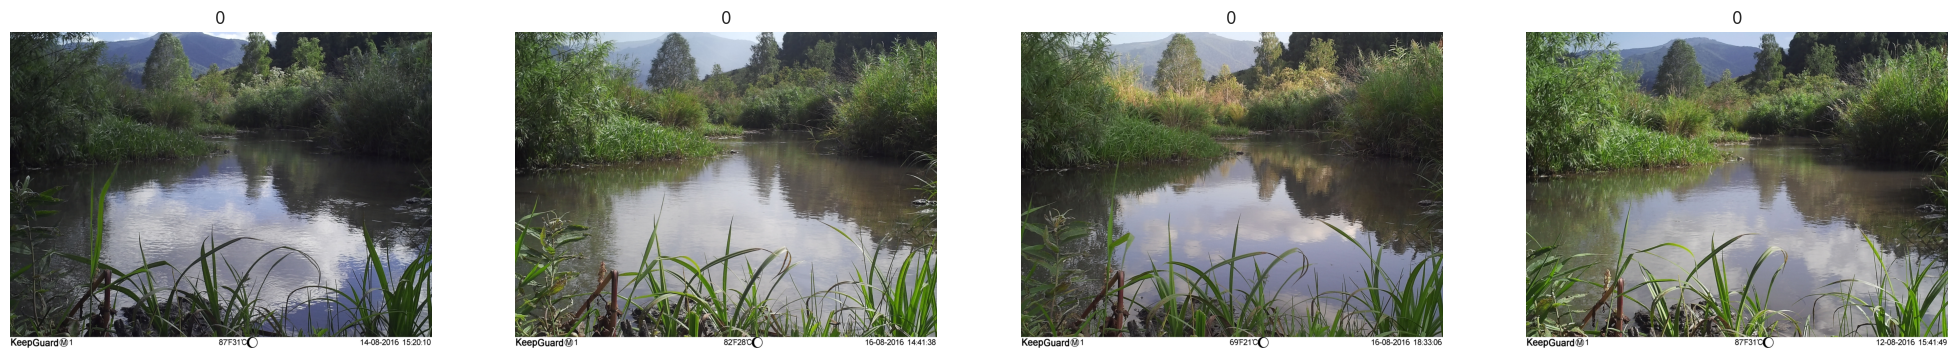

In [ ]:
import random #демонстрация работы модели на рандомных картинках из теста

fig, axs = plt.subplots(1, 4, figsize=(25, 5))
for i in range(4):
  idx=random.randrange(len(x_test))
  img_path = x_test[idx]
  axs[i].set_title(prediction[idx])
  axs[i].imshow(Image.open(img_path))
  axs[i].axis('off')

# Отрисовка всего полотна
plt.show()